# SISTEMA DE RECOMENDACIÓN
## Sprint 03
### Bertero, Buraschi y Rodriguez

### Imports

In [1]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808330 sha256=44828e864ff9fbc4766f1507e9b5853cc782c52f17f95a636333a91e8ac9cd5c
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DataFrames

In [5]:
# RATINGS
ratings = pd.read_csv('drive/MyDrive/u.data', sep='\t', header=None)
ratings.columns = ['account_id', 'content_id', 'rating', 'timestamp']
ratings.head()

,account_id,content_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# TRAINING - TEST - VALIDATION
ratings_train = pd.read_csv('/content/drive/MyDrive/ua.base',sep='\t', names=ratings.columns, encoding='latin-1')
ratings_test = pd.read_csv('/content/drive/MyDrive/ua.test', sep='\t', names=ratings.columns, encoding='latin-1')

validation_data_test, test_data = train_test_split(ratings_test, test_size=0.2, random_state=42)
validation_data_train, train_data = train_test_split(ratings_train, test_size=len(test_data), random_state=42)
validation_data = pd.concat([train_data, test_data])

# Save
# ratings_train.to_csv('/content/drive/MyDrive/ua.train', sep='\t', header=False, index=False)
# test_data.to_csv('/content/drive/MyDrive/ua.test', sep='\t', header=False, index=False)
# validation_data.to_csv('/content/drive/MyDrive/ua.validation', sep='\t', header=False, index=False)

In [7]:
# MOVIES DB
items_cols = ['movie_id' , 'title' , 'release_date' , 'video_release_date' , 'IMDb_URL' , 'unknown' , 'Action' , 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',\
              'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('/content/drive/MyDrive/u.item', sep='|', encoding='latin-1', names=items_cols, parse_dates=True)

In [8]:
# GENRES DB
genres_cols = ['Genre', 'Index']
genres = pd.read_csv('/content/drive/MyDrive/u.genre', sep='|', encoding='latin-1', names=genres_cols, parse_dates=True, index_col='Index')

### EDA

**Info**

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   account_id  100000 non-null  int64
 1   content_id  100000 non-null  int64
 2   rating      100000 non-null  int64
 3   timestamp   100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


**Null**

In [10]:
ratings.isna().sum()

account_id    0
content_id    0
rating        0
timestamp     0
dtype: int64

**Description**

In [11]:
ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

**Shapes**

In [12]:
print(f'Training shape: {ratings_train.shape}')
print(f'Training users: {ratings_train.account_id.nunique()}')
print(f'Training movies: {ratings_train.content_id.nunique()}')
print(f'Test shape: {ratings_test.shape}')
print(f'Test users: {ratings_test.account_id.nunique()}')
print(f'Test movies: {ratings_train.content_id.nunique()}')
print(f'Validation shape: {validation_data.shape}')
print(f'Validation users: {validation_data.account_id.nunique()}')
print(f'Validation movies: {ratings_train.content_id.nunique()}')

Training shape: (90570, 4)
Training users: 943
Training movies: 1680
Test shape: (9430, 4)
Test users: 943
Test movies: 1680
Validation shape: (3772, 4)
Validation users: 909
Validation movies: 1680


**Data**

In [13]:
n_ratings = len(ratings)
n_movies = ratings['content_id'].nunique()
n_users = ratings['account_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100000
Number of unique movieId's: 1682
Number of unique users: 943
Average number of ratings per user: 106.04
Average number of ratings per movie: 59.45


**Movie rating distribution**

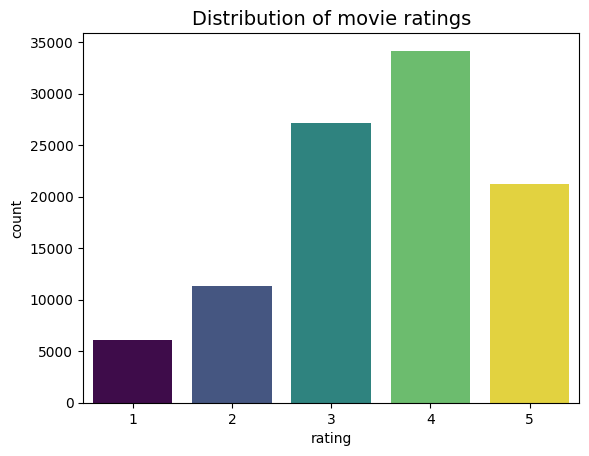

In [14]:
sns.countplot(x="rating", data=ratings, palette="viridis", hue='rating', legend=False)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

**Means**

In [15]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")
mean_ratings = ratings.groupby('account_id')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.59.


**Years data**

In [16]:
# Convert 'timestamp' to format 'Y/m/d'
ratings["timestamp"] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings_train["timestamp"] = pd.to_datetime(ratings_train['timestamp'], unit='s')
ratings_test["timestamp"] = pd.to_datetime(ratings_test['timestamp'], unit='s')
validation_data["timestamp"] = pd.to_datetime(validation_data['timestamp'], unit='s')
ratings.sample(5)

,account_id,content_id,rating,timestamp
75267,505,183,3,1998-03-08 05:03:12
38543,552,1620,3,1997-11-11 04:21:11
99594,537,25,2,1998-01-28 23:29:59
34161,435,697,4,1998-01-07 00:36:12
67538,909,116,5,1998-04-07 03:33:30


In [17]:
plot_df = ratings.copy()
plot_df["year"] = ratings.timestamp.dt.year
plot_df = plot_df.groupby("year", as_index=False).count()[["year", "account_id"]]
plot_df.columns = ["year", "reviews_count"]
plot_df.head()

,year,reviews_count
0,1997,52899
1,1998,47101


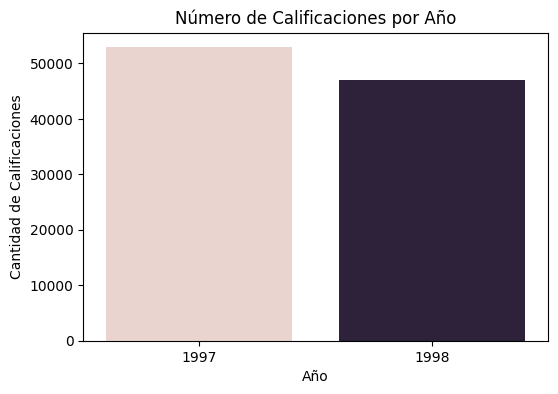

In [18]:
plt.figure(figsize=(6, 4))
sns.barplot(x="year", y="reviews_count", data=plot_df, hue='year', legend=False)
plt.title('Número de Calificaciones por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Calificaciones')
plt.show()

**Top movies rated**

In [19]:
movie_ratings = pd.merge(ratings, movies, left_on='content_id', right_on='movie_id')
movie_ratings['title'].value_counts()[0:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

**Average rating**

In [20]:
movie_stats = ratings.groupby('content_id')['rating'].agg(['count', 'mean'])
movie_avg_votes = movie_stats['count'].mean()
movie_avg_rating = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {movie_avg_votes:.2f}")
print(f"Average rating for a given movie: {movie_avg_rating:.2f}")

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


**Lowest rated movie**

In [21]:
mean_ratings = ratings.groupby('content_id')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movie_id']==lowest_rated][['movie_id', 'title', 'release_date']]

,movie_id,title,release_date
313,314,3 Ninjas: High Noon At Mega Mountain (1998),01-Jan-1997


In [22]:
ratings[ratings['content_id']==lowest_rated]

,account_id,content_id,rating,timestamp
2997,13,314,1,1998-01-11 17:08:05
3425,2,314,1,1998-03-04 02:54:45
13859,206,314,1,1998-02-22 20:39:08
41251,609,314,1,1998-02-07 23:59:01
78117,537,314,1,1998-01-28 23:13:59


**Highest rated movie**

In [23]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movie_id']==highest_rated][['movie_id', 'title', 'release_date']]

,movie_id,title,release_date
813,814,"Great Day in Harlem, A (1994)",01-Jan-1994


In [24]:
ratings[ratings['content_id']==highest_rated]

,account_id,content_id,rating,timestamp
6519,13,814,5,1998-02-01 03:04:21


**Bayesian Average**
> equilibrar la calificación promedio de los elementos con la calificación promedio global del conjunto de datos.

In [25]:
def bayesian_avg(ratings):
    bayesian_avg = (movie_avg_votes*movie_avg_rating+ratings.sum())/(movie_avg_votes+ratings.count())
    return round(bayesian_avg, 3)

In [26]:
bayesian_avg_ratings = ratings.groupby('content_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['content_id', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='content_id')

**Top rated movies weighted**

In [27]:
movie_stats = movie_stats.merge(movies[['movie_id', 'title']], left_on='content_id', right_on='movie_id')
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,content_id,count,mean,bayesian_avg,movie_id,title
49,50,583,4.358491,4.240,50,Star Wars (1977)
317,318,298,4.466443,4.235,318,Schindler's List (1993)
63,64,283,4.445230,4.208,64,"Shawshank Redemption, The (1994)"
482,483,243,4.456790,4.185,483,Casablanca (1942)
11,12,267,4.385768,4.147,12,"Usual Suspects, The (1995)"


**Worst rated movies weighted**

In [28]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,content_id,count,mean,bayesian_avg,movie_id,title
687,688,44,1.840909,2.551,688,Leave It to Beaver (1997)
686,687,69,2.188406,2.599,687,McHale's Navy (1997)
121,122,106,2.339623,2.604,122,"Cable Guy, The (1996)"
889,890,43,1.953488,2.605,890,Mortal Kombat: Annihilation (1997)
987,988,86,2.313953,2.625,988,"Beautician and the Beast, The (1997)"


### Data Pre-processing
> Filtrado colaborativo para generar recomendaciones para usuarios.

**Interactions**

> Interacciones  para el set de train y test con variables de referencia: "account_id", "content_id", "rating"

In [29]:
# Columns
matrix_columns = ["account_id", "content_id", "rating"]

**Train**

In [30]:
interactions_train = ratings_train[matrix_columns]
interactions_train.head()

,account_id,content_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [31]:
interactions_train_matrix = interactions_train.pivot(index="account_id", columns="content_id", values="rating").fillna(0)
interactions_train_matrix.sample(5)

content_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
account_id,,,,,,,,,,,,,,,,,,,,,
321,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
648,5.0,4.0,0.0,1.0,4.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
interactions_train_matrix.shape

(943, 1680)

In [33]:
interactions_train_matrix.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            934, 935, 936, 937, 938, 939, 940, 941, 942, 943],
           dtype='int64', name='account_id', length=943)

In [34]:
interactions_train_matrix.fillna(0).sample(5)

content_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
account_id,,,,,,,,,,,,,,,,,,,,,
320,3.0,4.0,4.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Test**

In [35]:
interactions_test = ratings_test[matrix_columns]
interactions_test.head()

,account_id,content_id,rating
0,1,20,4
1,1,33,4
2,1,61,4
3,1,117,3
4,1,155,2


In [36]:
interactions_test_matrix = interactions_test.pivot(index="account_id", columns="content_id", values="rating").fillna(0)
interactions_test_matrix.sample(5)

content_id,1,2,3,4,5,6,7,8,9,10,...,1591,1592,1600,1612,1617,1646,1653,1656,1662,1664
account_id,,,,,,,,,,,,,,,,,,,,,
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
879,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
interactions_test_matrix.shape

(943, 1129)

In [38]:
interactions_test_matrix.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            934, 935, 936, 937, 938, 939, 940, 941, 942, 943],
           dtype='int64', name='account_id', length=943)

In [39]:
interactions_test_matrix.fillna(0).sample(5)

content_id,1,2,3,4,5,6,7,8,9,10,...,1591,1592,1600,1612,1617,1646,1653,1656,1662,1664
account_id,,,,,,,,,,,,,,,,,,,,,
567,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Cheking train and test shapes**

In [40]:
train_accounts = interactions_train["account_id"].unique()
test_accounts = interactions_test["account_id"].unique()

train_content = interactions_train["content_id"].unique()
test_content = interactions_test["content_id"].unique()

missing_accounts_in_test = set(train_accounts) - set(test_accounts)
missing_content_in_test = set(train_content) - set(test_content)

print("Missing accounts in test set:", missing_accounts_in_test)
print("Missing content in test set:", missing_content_in_test)

missing_values_train = interactions_train_matrix.isnull().sum().sum()
missing_values_test = interactions_test_matrix.isnull().sum().sum()

print("Missing values in train matrix:", missing_values_train)
print("Missing values in test matrix:", missing_values_test)


Missing accounts in test set: set()
Missing content in test set: {18, 34, 35, 37, 41, 43, 74, 75, 84, 104, 149, 158, 247, 320, 373, 374, 383, 388, 389, 390, 394, 397, 415, 437, 438, 445, 446, 450, 453, 503, 534, 543, 545, 548, 555, 556, 563, 572, 574, 575, 579, 594, 599, 600, 618, 621, 624, 653, 666, 667, 668, 677, 698, 700, 706, 711, 726, 733, 757, 759, 766, 776, 777, 779, 782, 784, 786, 788, 793, 795, 798, 799, 800, 802, 803, 804, 810, 812, 814, 817, 822, 830, 837, 838, 848, 850, 851, 852, 857, 858, 861, 867, 868, 870, 891, 897, 907, 910, 911, 913, 914, 917, 927, 933, 940, 946, 957, 965, 966, 967, 968, 970, 972, 973, 981, 985, 992, 999, 1000, 1001, 1002, 1013, 1020, 1026, 1027, 1045, 1053, 1055, 1056, 1058, 1064, 1066, 1069, 1071, 1072, 1075, 1077, 1080, 1082, 1085, 1087, 1088, 1092, 1096, 1102, 1103, 1106, 1108, 1111, 1113, 1117, 1120, 1122, 1123, 1124, 1125, 1128, 1130, 1135, 1136, 1138, 1139, 1140, 1141, 1144, 1145, 1146, 1148, 1151, 1154, 1155, 1156, 1158, 1159, 1162, 1164, 1165,

In [41]:
# Identify missing columns
missing_columns = set(interactions_train_matrix.columns) - set(interactions_test_matrix.columns)

# Add missing columns with default values
for column in missing_columns:
    interactions_test_matrix[column] = 0

# Reorder columns to match train
interactions_test_matrix = interactions_test_matrix[interactions_train_matrix.columns]

<ipython-input-41-ed9b9676c716>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions_test_matrix[column] = 0
<ipython-input-41-ed9b9676c716>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  interactions_test_matrix[column] = 0
<ipython-input-41-ed9b9676c716>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = 

**Compressed Sparse Row**
> En lugar de almacenar cada elemento de la matriz, en un formato disperso se almacenan solo los elementos no cero junto con información sobre su posición.

In [42]:
interactions_train_matrix_csr = csr_matrix(interactions_train_matrix.values) # Train
interactions_test_matrix_csr = csr_matrix(interactions_test_matrix.values) # Test

In [43]:
print(f'Train CRS matrix shape: {interactions_train_matrix_csr.shape}')
print(f'Test CRS matrix shape: {interactions_test_matrix_csr.shape}')

Train CRS matrix shape: (943, 1680)
Test CRS matrix shape: (943, 1680)


In [44]:
print(interactions_train_matrix_csr.todense()[:10, :10])

[[5. 3. 4. 3. 3. 5. 4. 1. 5. 3.]
 [4. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0. 0. 2. 4. 4. 0.]
 [0. 0. 0. 5. 0. 0. 5. 5. 5. 4.]
 [0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 4. 0. 0. 0.]
 [4. 0. 0. 4. 0. 0. 0. 0. 4. 0.]]


In [45]:
print(interactions_train_matrix.stack().unique())

[5. 3. 4. 1. 2. 0.]


In [46]:
n_total = interactions_train_matrix_csr.shape[0]*interactions_train_matrix_csr.shape[1]
n_ratings = interactions_train_matrix_csr.nnz
sparsity = n_ratings/n_total
print(f'Number of rows in Train: {interactions_train_matrix_csr.shape[0]}')
print(f'Number of columns in Train: {interactions_train_matrix_csr.shape[1]}')
print(f'Total number of elements in Train: {n_total}')
print(f'Number of non-zero elements in Train: {n_ratings}')
print(f'Train Matrix sparsity: {round(sparsity * 100, 2)}%')

Number of rows in Train: 943
Number of columns in Train: 1680
Total number of elements in Train: 1584240
Number of non-zero elements in Train: 90570
Train Matrix sparsity: 5.72%


In [47]:
n_total = interactions_test_matrix_csr.shape[0]*interactions_train_matrix_csr.shape[1]
n_ratings = interactions_test_matrix_csr.nnz
sparsity = n_ratings/n_total
print(f'Number of rows in Test: {interactions_test_matrix_csr.shape[0]}')
print(f'Number of columns in Test: {interactions_test_matrix_csr.shape[1]}')
print(f'Total number of elements in Test: {n_total}')
print(f'Number of non-zero elements in Test: {n_ratings}')
print(f'Train Matrix sparsity: {round(sparsity * 100, 2)}%')

Number of rows in Test: 943
Number of columns in Test: 1680
Total number of elements in Test: 1584240
Number of non-zero elements in Test: 9428
Train Matrix sparsity: 0.6%


**Cold Start**

> Se busca usuarios que estén en el set de test y NO en el de train: COLD START

In [48]:
ratings_test[~ratings_test.account_id.isin(ratings_train.account_id.unique())].account_id.nunique()

0

In [49]:
n_ratings_per_user = interactions_train_matrix_csr.getnnz(axis=1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 727 movies.
Least active user rated 10 movies.


In [50]:
n_ratings_per_movie = interactions_train_matrix_csr.getnnz(axis=0)
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 495 ratings.
Least rated movie has 1 ratings.


#### Mapping

In [51]:
def mapping(rang):
  ids = list(rang)
  mapping_dict = {}
  counter = 0
  for i in ids:
    mapping_dict[i] = counter
    counter += 1
  return mapping_dict

**Index dictionaries**

In [52]:
# Train
account_dict_train = mapping(interactions_train_matrix.index)
account_inv_dict_train = {v: k for k, v in account_dict_train.items()}

content_dict_train = mapping(interactions_train_matrix.columns)
content_inv_dict_train = {v: k for k, v in content_dict_train.items()}

#Test
account_dict_test = mapping(interactions_test_matrix.index)
account_inv_dict_test = {v: k for k, v in account_dict_test.items()}

content_dict_test = mapping(interactions_test_matrix.columns)
content_inv_dict_test = {v: k for k, v in content_dict_test.items()}

### MODELIZACIÓN

**NaN Handler**

In [53]:
# FillNaN

# Train
dense_matrix = pd.DataFrame(interactions_train_matrix_csr.todense())
dense_matrix_filled = dense_matrix.fillna(0)
interactions_train_matrix_csr = csr_matrix(dense_matrix_filled.values)

# Test
dense_matrix = pd.DataFrame(interactions_test_matrix_csr.todense())
dense_matrix_filled = dense_matrix.fillna(0)
interactions_test_matrix_csr = csr_matrix(dense_matrix_filled.values)

In [54]:
# Verify
nan_mask = np.isnan(interactions_train_matrix_csr.data)
if np.any(nan_mask):
      interactions_train_matrix_csr.data[nan_mask] = 0

inf_mask = np.isinf(interactions_train_matrix_csr.data)
if np.any(inf_mask):
    interactions_train_matrix_csr.data[inf_mask] = 0

#### Pure Python

In [55]:
def find_content_by_id(content_id):
    # Encontrar cuentas que han calificado el contenido especificado de manera positiva (calificación > 4)
    similar_accounts = ratings_train[(ratings_train["content_id"] == content_id) & (ratings_train["rating"] > 4)]["account_id"].unique()
    # Encontrar contenido que estas cuentas similares han calificado positivamente (calificación > 4)
    similar_accounts_recs = ratings_train[(ratings_train["account_id"].isin(similar_accounts)) & (ratings_train["rating"] > 4)]["content_id"]
    # Calcular el porcentaje de veces que aparece cada contenido recomendado entre las cuentas similares
    similar_accounts_recs = similar_accounts_recs.value_counts() / len(similar_accounts)
    # Filtrar el contenido recomendado que aparece en más del 10% de las cuentas similares
    similar_accounts_recs = similar_accounts_recs[similar_accounts_recs > .10]

    # Encontrar todas las cuentas que han calificado el contenido recomendado seleccionado
    all_accounts = ratings_train[(ratings_train["content_id"].isin(similar_accounts_recs.index)) & (ratings_train["rating"] > 4)]
    # Calcular el porcentaje de veces que aparece cada contenido recomendado entre todas las cuentas
    all_accounts_recs = all_accounts["content_id"].value_counts() / len(all_accounts["account_id"].unique())

    # Combinar los porcentajes de contenido recomendado para cuentas similares y todas las cuentas
    rec_percentages = pd.concat([similar_accounts_recs, all_accounts_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    # Calcular un puntaje dividiendo el porcentaje de contenido recomendado entre cuentas similares por el de todas las cuentas
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    # Ordenar por puntaje de forma descendente y seleccionar las primeras 10 recomendaciones
    rec_percentages = rec_percentages.sort_values("score", ascending=False)

    # Combinar con información de películas y seleccionar solo las columnas "score" y "title"
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movie_id")[["score", "title"]]

In [56]:
def find_content_by_account(account_id):

    # Encontrar contenido calificado (mayor a 4) por la cuenta especificada
    account_content = ratings_train[(ratings_train["account_id"] == account_id) \
                                    & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]["content_id"].unique()
    # Encontrar cuentas que han calificado el contenido especificado de manera positiva (calificación > 4)
    similar_accounts = ratings_train[(ratings_train["content_id"].isin(account_content)) \
                                     & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]["account_id"]
    # Encontrar contenido que estas cuentas similares han calificado positivamente (calificación > 4)
    similar_accounts_recs = ratings_train[(ratings_train["account_id"].isin(similar_accounts)) \
                                          & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9))) \
                                          & ~(ratings_train["content_id"].isin(account_content))]["content_id"]
    # Calcular el porcentaje de veces que aparece cada contenido recomendado entre las cuentas similares
    similar_accounts_recs = similar_accounts_recs.value_counts() / len(similar_accounts)
    # Filtrar el contenido recomendado que aparece en más del 10% de las cuentas similares
    similar_accounts_recs = similar_accounts_recs[similar_accounts_recs > .10]

    # Encontrar todas las cuentas que han calificado el contenido recomendado seleccionado
    all_accounts = ratings_train[(ratings_train["content_id"].isin(similar_accounts_recs.index)) \
                                 & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]
    # Calcular el porcentaje de veces que aparece cada contenido recomendado entre todas las cuentas
    all_accounts_recs = all_accounts["content_id"].value_counts() / len(all_accounts["account_id"].unique())

    # Combinar los porcentajes de contenido recomendado para cuentas similares y todas las cuentas
    rec_percentages = pd.concat([similar_accounts_recs, all_accounts_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    # Calcular un puntaje dividiendo el porcentaje de contenido recomendado entre cuentas similares por el de todas las cuentas
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    # Ordenar por puntaje de forma descendente y seleccionar las primeras 10 recomendaciones
    rec_percentages = rec_percentages.sort_values("score", ascending=False)

    # Combinar con información de películas y seleccionar solo las columnas "score" y "title"
    return rec_percentages.head(20).merge(movies, left_index=True, right_on="movie_id")[['movie_id', "score", "title"]]

In [110]:
def find_content_by_account(account_id):
    account_content = ratings_train[(ratings_train["account_id"] == account_id) \
                                    & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]["content_id"].unique()
    similar_accounts = ratings_train[(ratings_train["content_id"].isin(account_content)) \
                                     & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]["account_id"]
    similar_accounts_recs = ratings_train[(ratings_train["account_id"].isin(similar_accounts)) \
                                          & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9))) \
                                          & ~(ratings_train["content_id"].isin(account_content))]["content_id"]
    similar_accounts_recs = similar_accounts_recs.value_counts() / len(similar_accounts)
    similar_accounts_recs = similar_accounts_recs[similar_accounts_recs > .10]
    all_accounts = ratings_train[(ratings_train["content_id"].isin(similar_accounts_recs.index)) \
                                 & (ratings_train["rating"] == (ratings_train["rating"].quantile(0.9)))]
    all_accounts_recs = all_accounts["content_id"].value_counts() / len(all_accounts["account_id"].unique())
    rec_percentages = pd.concat([similar_accounts_recs, all_accounts_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    result = rec_percentages.head(20).merge(movies, left_index=True, right_on="movie_id")[['movie_id']]
    return result.values.flatten().tolist()

In [111]:
find_content_by_account(80)

[238,
 132,
 423,
 134,
 496,
 474,
 603,
 357,
 427,
 191,
 69,
 185,
 98,
 168,
 12,
 7,
 79,
 89,
 318,
 174]

### k-Nearest Neighbors

In [59]:
def find_content_knn(content_id, matrix, content_dict, content_inv_dict, k, metric='cosine'):
    matrix = matrix.T
    neighbour_ids = []

    content_ind = content_dict[content_id]
    content_vec = matrix[content_ind]
    if isinstance(content_vec, (np.ndarray)):
        content_vec = content_vec.reshape(1,-1)

    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(matrix)
    neighbour = kNN.kneighbors(content_vec, return_distance=False)

    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(content_inv_dict[n])
    neighbour_ids.pop(0)

    return neighbour_ids

In [60]:
similar_movies = find_content_knn(80, interactions_train_matrix_csr, content_dict_train, content_inv_dict_train, k=10)
similar_movies

[67, 384, 780, 790, 386, 90, 364, 68, 217]

In [61]:
def recommend_knn(movie_id, metric):
  movie_titles = dict(zip(movies['movie_id'], movies['title']))
  similar_movies = find_content_knn(movie_id, interactions_train_matrix_csr, content_dict_train, content_inv_dict_train, k=10, metric=metric)
  movie_title = movie_titles[movie_id]
  print(f"Because you watched {movie_title}:")
  for i in similar_movies:
      print(f'*{i} {movie_titles[i]}')

In [62]:
# Metric values:  'cosine' | 'manhattan' | 'euclidean'
recommend_knn(50, 'cosine')

Because you watched Star Wars (1977):
*181 Return of the Jedi (1983)
*174 Raiders of the Lost Ark (1981)
*172 Empire Strikes Back, The (1980)
*210 Indiana Jones and the Last Crusade (1989)
*98 Silence of the Lambs, The (1991)
*1 Toy Story (1995)
*121 Independence Day (ID4) (1996)
*173 Princess Bride, The (1987)
*204 Back to the Future (1985)


### LightFM

In [63]:
# HyperParams
NUM_THREADS = 2
NUM_COMPONENTS = 32
NUM_EPOCHS = 12
ITEM_ALPHA = 1e-6

In [64]:
# MODELO
# model = LightFM(no_components=3, random_state=100, learning_rate=0.03)
# model = LightFM(learning_rate=0.05, loss='bpr')
# model = LightFM(learning_rate=0.05, loss='warp')
model = LightFM(loss='warp', item_alpha=ITEM_ALPHA, no_components=NUM_COMPONENTS)

In [65]:
# ENTRENAMIENTO
# model = model.fit(interactions_train_matrix_csr, epochs=NUM_EPOCHS)
%time model = model.fit(interactions_train_matrix_csr, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 1.44 s


In [66]:
# PRECISION
train_precision = precision_at_k(model, interactions_train_matrix_csr, k=10).mean()
test_precision = precision_at_k(model, interactions_test_matrix_csr, k=10).mean()

train_auc = auc_score(model, interactions_train_matrix_csr, num_threads=NUM_THREADS).mean()
test_auc = auc_score(model, interactions_test_matrix_csr, \
                     train_interactions=interactions_train_matrix_csr, \
                     num_threads=NUM_THREADS, \
                     check_intersections=False).mean()

print('Precision:\n train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC:\n train %.2f, test %.2f.' % (train_auc, test_auc))

Precision:
 train 0.67, test 0.11.
AUC:
 train 0.96, test 0.94.


**Recomends by accounts**

In [67]:
# Diccionario de almacenamiento
recomms_dict = {
    'account_id': [],
    'recomms': []
}

In [68]:
interactions_train_matrix.head()

content_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
account_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Se obtiene cantidad de usuarios y cantidad de items
n_accounts, n_contents = interactions_train_matrix.shape
content_ids = np.arange(n_contents)

In [70]:
# Por cada usuario del dataset de test, se generan recomendaciones
for account in tqdm(ratings_test.account_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index) del data usuado para train
    if account in list(interactions_train_matrix.index):
      # Si el usuario esta en train -no es cold start, se usa el modelo para recomendar
      account_x = account_dict_train[account] #se busca el indice del usuario en la matriz (transformamos id a indice)

      # Generar las predicciones para el usuario x
      preds = model.predict(user_ids = account_x, item_ids = content_ids)

      #Se ordenan las predicciones de menor a mayor y se toman 50.
      scores = pd.Series(preds)
      scores.index = interactions_train_matrix.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      #Se obtiene listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = ratings_train[ratings_train.account_id == account].content_id.unique()

      #Se filtra los contenidos ya vistos y quedarse con los primeros 20 (según consigna)
      recomms = [x for x in scores if x not in watched_contents][:20]

      # Se guardan las recomendaciones en el diccionario creado
      recomms_dict['account_id'].append(account)
      recomms_dict['recomms'].append(scores)

100%|██████████| 943/943 [00:02<00:00, 463.96it/s]


In [71]:
# Se convierte en df el diccionario creado
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.head()

,account_id,recomms
0,1,"[50, 100, 181, 56, 168, 7, 174, 1, 98, 121, 25..."
1,2,"[286, 300, 275, 301, 269, 258, 100, 285, 328, ..."
2,3,"[302, 300, 258, 346, 327, 288, 313, 328, 286, ..."
3,4,"[300, 258, 302, 288, 328, 313, 327, 333, 748, ..."
4,5,"[168, 99, 393, 94, 173, 386, 588, 63, 82, 210,..."


In [72]:
recomms_df.account_id.nunique()

943

In [73]:
def recommend_lightFM(model, matrix, account_id, account_dict, content_dict, nrec_items=10, show=True):
    n_accounts, n_contents = matrix.shape
    account_x = account_dict[account_id]

    scores = pd.Series(model.predict(account_x, np.arange(n_contents)))
    scores.index = matrix.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_contents = list(pd.Series(matrix.loc[account_id, :][matrix.loc[account_id, :] > 0].index).sort_values(ascending=False))

    # Filter
    filtered_scores = []

    for x in scores:
      if x not in known_contents \
        or ((matrix[x].sum() == 1) \
            and (matrix.loc[matrix[x] > 0, x].quantile(0.9))):
        filtered_scores.append(x)

    recomms = filtered_scores[:nrec_items]
    return recomms

In [74]:
interactions_train_matrix.head()

content_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
account_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
 n_accounts, n_contents = interactions_test_matrix.shape
 account_x = account_dict_test[account_x]
 scores = pd.Series(model.predict(account_x, np.arange(n_contents)))
 scores.index = interactions_test_matrix.columns
 scores_sorted = scores.sort_values(ascending=False)

In [76]:
recomms_test = recommend_lightFM(model, interactions_test_matrix, account_x, account_dict_test, content_dict_test, show=True)
recomms_test

[288, 100, 50, 1, 121, 222, 298, 294, 748, 405]

### Base de Datos
> Con descripción de películas según movie_id

In [77]:
movies.sample(5)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
152,153,"Fish Called Wanda, A (1988)",01-Jan-1988,NaN,http://us.imdb.com/M/title-exact?Fish%20Called...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165,166,Manon of the Spring (Manon des sources) (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Manon%20des%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
853,854,Bad Taste (1987),01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Bad%20Taste%2...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
909,910,Nil By Mouth (1997),06-Feb-1998,NaN,http://us.imdb.com/Title?Nil+By+Mouth+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,1013,Anaconda (1997),11-Apr-1997,NaN,http://us.imdb.com/M/title-exact?Anaconda%20%2...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [78]:
# Se compatibiliza la base de datos "ratings" con el nombre de la película según movie_id
data = pd.merge(ratings, movies, left_on='content_id', right_on='movie_id')
data.sample(5)

,account_id,content_id,rating,timestamp,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
83684,880,1095,3,1997-11-22 05:11:43,1095,High School High (1996),25-Oct-1996,NaN,http://us.imdb.com/M/title-exact?High%20School...,0,...,0,0,0,0,0,0,0,0,0,0
63425,274,877,3,1997-11-07 23:15:43,877,Excess Baggage (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Excess+Baggag...,0,...,0,0,0,0,0,1,0,0,0,0
89014,34,329,5,1998-02-27 18:06:48,329,Desperate Measures (1998),30-Jan-1998,NaN,http://us.imdb.com/Title?Desperate+Measures+(1...,0,...,0,0,0,0,0,0,0,1,0,0
12617,758,480,5,1997-12-13 01:06:53,480,North by Northwest (1959),01-Jan-1959,NaN,http://us.imdb.com/M/title-exact?North%20by%20...,0,...,0,0,0,0,0,0,0,1,0,0
31203,492,318,5,1997-11-19 20:04:38,318,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,...,0,0,0,0,0,0,0,0,1,0


In [79]:
# Nueva base de datos generada con sólo dos variables: movie_id y title
columns = ['movie_id', 'title']
movies = movies[columns]
movies.sample(10)

,movie_id,title
1586,1587,Terror in a Texas Town (1958)
1307,1308,Babyfever (1994)
1523,1524,Kaspar Hauser (1993)
255,256,When the Cats Away (Chacun cherche son chat) (...
832,833,Bulletproof (1996)
533,534,Traveller (1997)
63,64,"Shawshank Redemption, The (1994)"
1604,1605,Love Serenade (1996)
32,33,Desperado (1995)
218,219,"Nightmare on Elm Street, A (1984)"


#### Métricas

> En primera instancia, se generan las recomendaciones para cada tipo de usuario (identificación)

#### Train

In [80]:
cold_start_recomms = interactions_train \
    .groupby("content_id") \
    .agg({"rating": "mean"}) \
    .sort_values(by="rating", ascending=False) \
    .head(10) \
    .index \
    .to_list()

cold_start_recomms

[1500, 1189, 1201, 1122, 1467, 814, 1293, 1536, 1656, 1599]

In [81]:
accounts = interactions_train.account_id.unique()
accounts

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [134]:
# Diccionario de almacenamiento
recomms_dict = {
    "account_id": [],
    "recomms": [],
}

In [135]:
for account in accounts:
  # Recomms personalizadas
  if account in accounts:
    account_recomms = recommend_lightFM(model, interactions_train_matrix, account, account_dict_train, content_dict_train, nrec_items = 10, show = False)
    recomms_dict["account_id"].append(account)
    recomms_dict["recomms"].append(account_recomms)

In [136]:
# Se convierte en df el diccionario creado
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.sample(10)

,account_id,recomms
408,409,"[197, 513, 194, 185, 492, 488, 64, 302, 269, 519]"
187,188,"[172, 237, 117, 230, 96, 222, 183, 82, 385, 423]"
508,509,"[300, 286, 269, 313, 272, 750, 748, 333, 879, ..."
21,22,"[79, 82, 7, 576, 56, 188, 72, 183, 679, 67]"
694,695,"[300, 327, 258, 307, 332, 326, 313, 269, 245, ..."
928,929,"[183, 181, 176, 603, 64, 357, 79, 89, 180, 168]"
337,338,"[191, 511, 705, 199, 211, 482, 485, 529, 190, 14]"
42,43,"[204, 125, 151, 83, 739, 476, 815, 22, 419, 255]"
377,378,"[202, 356, 8, 65, 357, 553, 378, 367, 72, 934]"
599,600,"[849, 229, 554, 68, 227, 2, 33, 1228, 636, 55]"


#### Test

In [137]:
interactions_test.head()

,account_id,content_id,rating
0,1,20,4
1,1,33,4
2,1,61,4
3,1,117,3
4,1,155,2


In [138]:
ideal_recomms = interactions_test\
                  .sort_values(by=["account_id", "rating"], ascending=False)\
                  .groupby(["account_id"], as_index=False)\
                  .head()
ideal_recomms.head()

,account_id,content_id,rating
9423,943,186,5
9424,943,215,5
9420,943,11,4
9421,943,58,4
9422,943,111,4


In [139]:
# Diccionario de almacenamiento
recomms_test_dict = {
    "account_id": [],
    "recomms": [],
}

In [128]:
for account in accounts:
  # Recomms personalizadas
  if account in accounts:
    account_recomms = recommend_lightFM(model, interactions_test_matrix, account, account_dict_test, content_dict_test, nrec_items = 10, show = False)
    recomms_test_dict["account_id"].append(account)
    recomms_test_dict["recomms"].append(account_recomms)

In [129]:
# Se convierte en df el diccionario creado
recomms_test_df = pd.DataFrame(recomms_test_dict)
recomms_test_df.sample(10)

,account_id,recomms
426,427,"[286, 327, 332, 333, 289, 322, 303, 307, 887, ..."
865,866,"[286, 272, 340, 303, 346, 311, 345, 313, 315, ..."
924,925,"[288, 324, 358, 217, 268, 413, 258, 53, 452, 325]"
215,216,"[100, 7, 56, 475, 12, 11, 50, 121, 42, 168]"
312,313,"[174, 98, 69, 132, 435, 234, 135, 195, 194, 523]"
627,628,"[286, 258, 288, 328, 313, 294, 269, 301, 268, ..."
692,693,"[174, 98, 69, 56, 79, 22, 182, 234, 318, 64]"
415,416,"[294, 288, 258, 318, 300, 111, 237, 204, 50, 22]"
478,479,"[50, 222, 181, 121, 89, 176, 96, 195, 172, 1]"
223,224,"[237, 282, 215, 660, 699, 318, 471, 15, 125, 272]"


### MAP

In [140]:
df_map = ideal_recomms.merge(recomms_df, left_on="account_id",right_on="account_id")[["account_id", "content_id", "recomms"]]
df_map.columns = ["account_id", "ideal", "recomms"]
df_map.head()

,account_id,ideal,recomms
0,943,186,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
1,943,215,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
2,943,11,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
3,943,58,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
4,943,111,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"


In [141]:
registro_deseado = df_map.loc[df_map['account_id'] == 943]
registro_deseado

,account_id,ideal,recomms
0,943,186,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
1,943,215,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
2,943,11,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
3,943,58,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"
4,943,111,"[550, 82, 11, 232, 29, 176, 265, 186, 144, 7]"


In [142]:
aps = []  # lista vacía para ir almacenando la AP de cada recomendación

for pred, ideal in df_map[["recomms", "ideal"]].values:
    n = len(pred)
    if n > 0:
        arange = np.arange(n, dtype=np.int32) + 1.
        rel_k = np.in1d(pred[:n], [ideal])
        tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum()
        denom = arange[rel_k]
        ap = (tp / denom).sum() / len([ideal])
        aps.append(ap)

In [143]:
map = np.mean(aps)
print(f'mean average precision = {round(map, 5)}')

mean average precision = 0.1343
